/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]


Training with prompt: Evaluate the sentiment: '{}' Sentiment: {}


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Train Loss: 0.2833 | Val Loss: 0.2038 | Val F1: 0.9064
Epoch 2 | Train Loss: 0.1885 | Val Loss: 0.2000 | Val F1: 0.9097
Epoch 3 | Train Loss: 0.1163 | Val Loss: 0.2222 | Val F1: 0.9012
Epoch 4 | Train Loss: 0.0696 | Val Loss: 0.2702 | Val F1: 0.8968
Epoch 5 | Train Loss: 0.0387 | Val Loss: 0.5174 | Val F1: 0.8975


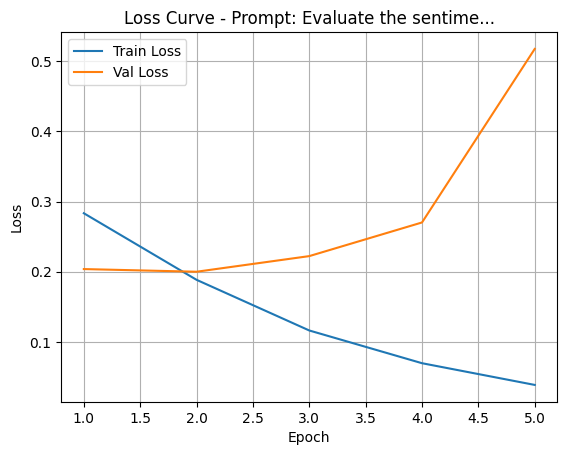

Test Results - Prompt: Evaluate the sentiment: '{}' Sentiment: {}
Accuracy: 0.9200 | F1: 0.9187 | Precision: 0.9215 | Recall: 0.9200


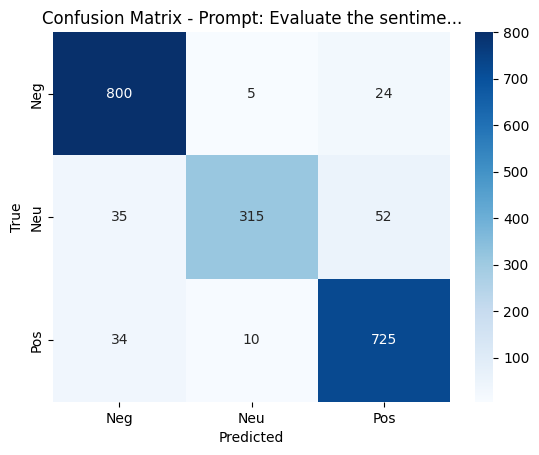


Training with prompt: Review says: '{}' -> The sentiment is {}.


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Train Loss: 0.3450 | Val Loss: 0.2025 | Val F1: 0.9099
Epoch 2 | Train Loss: 0.1812 | Val Loss: 0.1812 | Val F1: 0.9237
Epoch 3 | Train Loss: 0.1016 | Val Loss: 0.2713 | Val F1: 0.9087
Epoch 4 | Train Loss: 0.0684 | Val Loss: 0.4144 | Val F1: 0.9007
Epoch 5 | Train Loss: 0.0371 | Val Loss: 0.4571 | Val F1: 0.8906


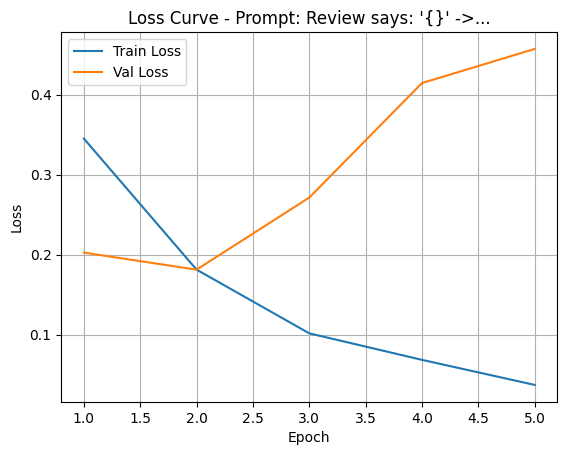

Test Results - Prompt: Review says: '{}' -> The sentiment is {}.
Accuracy: 0.9220 | F1: 0.9208 | Precision: 0.9225 | Recall: 0.9220


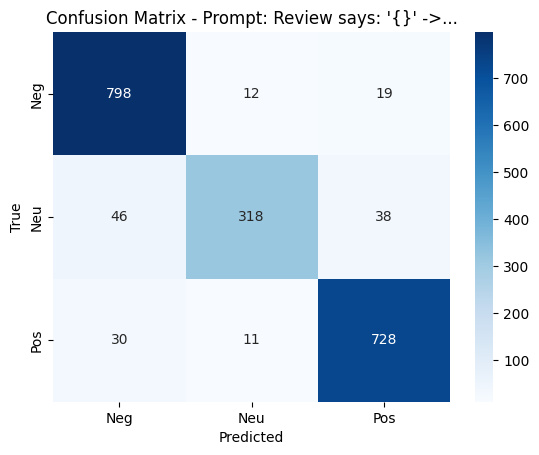


Training with prompt: Given this review: '{}' we determine the sentiment as {}.


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Train Loss: 0.3317 | Val Loss: 0.2403 | Val F1: 0.8816
Epoch 2 | Train Loss: 0.1821 | Val Loss: 0.2095 | Val F1: 0.9115
Epoch 3 | Train Loss: 0.1258 | Val Loss: 0.2157 | Val F1: 0.9114
Epoch 4 | Train Loss: 0.0638 | Val Loss: 0.3275 | Val F1: 0.8952
Epoch 5 | Train Loss: 0.0397 | Val Loss: 0.4770 | Val F1: 0.8972


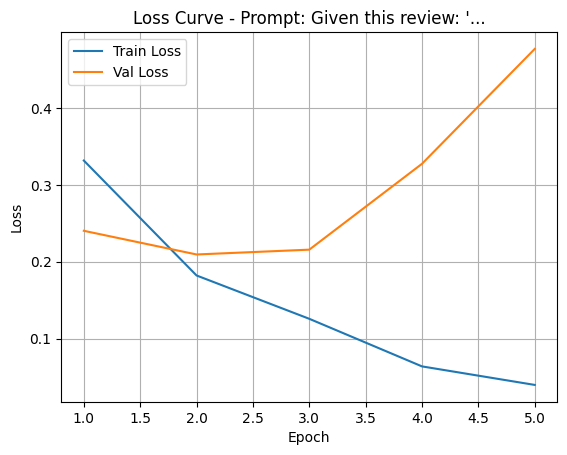

Test Results - Prompt: Given this review: '{}' we determine the sentiment as {}.
Accuracy: 0.9195 | F1: 0.9187 | Precision: 0.9283 | Recall: 0.9195


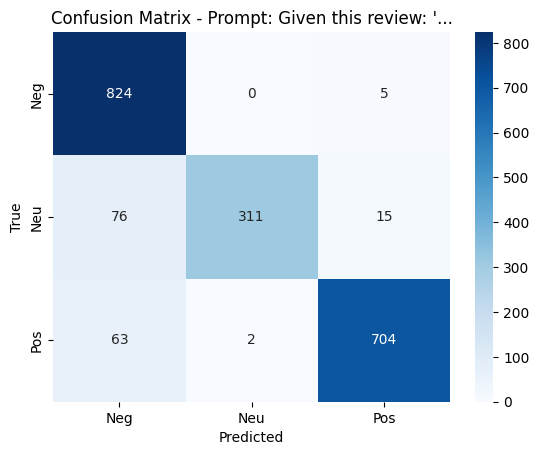


Best Prompt: Review says: '{}' -> The sentiment is {}. with F1: 0.9237


In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification


class YelpDataset(Dataset):
    def __init__(self, df, tokenizer, prompt_template, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.prompt_template = prompt_template
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['text']
        label = self.df.iloc[idx]['label']
        label_map = {0: "negative", 1: "neutral", 2: "positive"}
        input_text = self.prompt_template.format(text, label_map[label])
        encoding = self.tokenizer(
            input_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'text': text
        }


class SentimentClassifier:
    def __init__(self, model_name='distilgpt2', num_labels=3, max_length=256, batch_size=16, num_epochs=5):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.max_length = max_length
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.model_name = model_name
        self.num_labels = num_labels
        self.prompt_templates = [
            "Evaluate the sentiment: '{}' Sentiment: {}",
            "Review says: '{}' -> The sentiment is {}.",
            "Given this review: '{}' we determine the sentiment as {}."
        ]

    def load_data(self, train_path, val_path, test_path):
        train_df = pd.read_csv(train_path)
        val_df = pd.read_csv(val_path)
        test_df = pd.read_csv(test_path)

        def map_label(label):
            if label in [0, 1]: return 0
            if label == 2: return 1
            if label in [3, 4]: return 2
            raise ValueError("Invalid label")

        for df in [train_df, val_df, test_df]:
            df['label'] = df['label'].apply(map_label)

        self.train_df, self.val_df, self.test_df = train_df, val_df, test_df
        counts = train_df['label'].value_counts().sort_index()
        total = len(train_df)
        self.class_weights = torch.tensor([total / (3 * c) for c in counts], dtype=torch.float).to(self.device)

    def compute_metrics(self, preds, labels):
        num_classes = self.num_labels
        cm = confusion_matrix(labels, preds)
        acc = np.mean(np.array(preds) == np.array(labels))

        precision_list, recall_list, f1_list = [], [], []

        for cls in range(num_classes):
            TP = cm[cls, cls]
            FP = cm[:, cls].sum() - TP
            FN = cm[cls, :].sum() - TP

            precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

        weighted_avg = lambda metric_list: np.average(metric_list, weights=[(np.array(labels) == i).sum() for i in range(num_classes)])

        return (
            acc,
            weighted_avg(f1_list),
            weighted_avg(precision_list),
            weighted_avg(recall_list)
        )

    def train_and_evaluate(self):
        best_val_f1 = 0
        best_prompt = None
        results = {}

        for prompt in self.prompt_templates:
            print(f"\nTraining with prompt: {prompt}")
            train_loader = DataLoader(YelpDataset(self.train_df, self.tokenizer, prompt, self.max_length), batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(YelpDataset(self.val_df, self.tokenizer, prompt, self.max_length), batch_size=self.batch_size)
            test_loader = DataLoader(YelpDataset(self.test_df, self.tokenizer, prompt, self.max_length), batch_size=self.batch_size)

            model = GPT2ForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels)
            model.config.pad_token_id = self.tokenizer.pad_token_id
            model.to(self.device)

            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
            warmup_steps = int(0.1 * len(train_loader) * self.num_epochs)
            base_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda s: min((s + 1) / warmup_steps, 1))
            plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5, min_lr=1e-6)

            best_prompt_f1 = 0
            best_epoch = 0
            losses = {'train': [], 'val': []}

            for epoch in range(self.num_epochs):
                model.train()
                epoch_loss = 0
                for step, batch in enumerate(train_loader):
                    optimizer.zero_grad()
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)
                    loss = model(input_ids, attention_mask=attention_mask, labels=labels).loss
                    loss.backward()
                    optimizer.step()
                    if step < warmup_steps:
                        base_scheduler.step()
                    epoch_loss += loss.item()
                avg_train_loss = epoch_loss / len(train_loader)

                # Validation
                model.eval()
                val_preds, val_labels, val_loss = [], [], 0
                with torch.no_grad():
                    for batch in val_loader:
                        input_ids = batch['input_ids'].to(self.device)
                        attention_mask = batch['attention_mask'].to(self.device)
                        labels = batch['labels'].to(self.device)
                        output = model(input_ids, attention_mask=attention_mask, labels=labels)
                        val_loss += output.loss.item()
                        preds = torch.argmax(output.logits, dim=1)
                        val_preds.extend(preds.cpu().numpy())
                        val_labels.extend(labels.cpu().numpy())
                avg_val_loss = val_loss / len(val_loader)
                losses['train'].append(avg_train_loss)
                losses['val'].append(avg_val_loss)
                val_acc, val_f1, _, _ = self.compute_metrics(val_preds, val_labels)
                plateau_scheduler.step(avg_val_loss)
                print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {val_f1:.4f}")

                if val_f1 > best_prompt_f1:
                    best_prompt_f1 = val_f1
                    best_epoch = epoch + 1
                    torch.save(model.state_dict(), f'model_{prompt[:10]}.pt')

            # Plot Loss
            plt.plot(range(1, self.num_epochs + 1), losses['train'], label='Train Loss')
            plt.plot(range(1, self.num_epochs + 1), losses['val'], label='Val Loss')
            plt.title(f"Loss Curve - Prompt: {prompt[:20]}...")
            plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(); plt.show()

            # Test best model
            model.load_state_dict(torch.load(f'model_{prompt[:10]}.pt'))
            model.eval()
            test_preds, test_labels = [], []
            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)
                    outputs = model(input_ids, attention_mask=attention_mask)
                    preds = torch.argmax(outputs.logits, dim=1)
                    test_preds.extend(preds.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())

            acc, f1, precision, recall = self.compute_metrics(test_preds, test_labels)
            cm = confusion_matrix(test_labels, test_preds)
            print(f"Test Results - Prompt: {prompt}\nAccuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
            plt.title(f"Confusion Matrix - Prompt: {prompt[:20]}...")
            plt.xlabel("Predicted"); plt.ylabel("True")
            plt.show()

            results[prompt] = {'acc': acc, 'f1': f1, 'precision': precision, 'recall': recall}

            if best_prompt_f1 > best_val_f1:
                best_val_f1 = best_prompt_f1
                best_prompt = prompt

        print(f"\nBest Prompt: {best_prompt} with F1: {best_val_f1:.4f}")
        return results


# Usage:
classifier = SentimentClassifier()
classifier.load_data('/content/train.csv',
                      '/content/val.csv',
                      '/content/test.csv')
results = classifier.train_and_evaluate()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
